In [35]:
import pandas as pd
import numpy as np

# Classification Model

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [3]:
df = pd.read_csv('data/habitat-suitability.csv')

In [24]:
labelled_df = df.sample(n=30)
print(len(labelled_df))
non_labelled_df = df.drop(labelled_df.index)
print(len(non_labelled_df ))

30
99970


In [41]:
def classificationModel(labelled_df, unlabelled_df):

    X = labelled_df.drop('Suitable', axis=1)
    y = labelled_df['Suitable']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    log_reg = LogisticRegression(random_state=42)
    log_reg.fit(X_train_scaled, y_train)

    # Step 5: Predictions and evaluation
    y_pred = log_reg.predict(X_test_scaled)

    # Performance
    sample_accuracy = accuracy_score(y_test, y_pred)
    # sample_confusion_matrix = confusion_matrix(y_test, y_pred)
    # Prediction on unlabelled data
    X_full_test = non_labelled_df.drop('Suitable', axis=1)
    y_full_test = non_labelled_df['Suitable']
    X_full_test_scaled = scaler.transform(X_full_test)
    y_full_pred = log_reg.predict(X_full_test_scaled)

    full_accuracy = accuracy_score(y_full_test, y_full_pred)
    # full_confusion_matrix = confusion_matrix(y_full_test, y_full_pred)


    return sample_accuracy,  full_accuracy #, sample_confusion_matrix,full_confusion_matrix

# Random Active Learning

In [68]:
sample_accuracy = []
full_accuracy = []


_, current_sample = train_test_split(df, test_size=10, random_state=42, stratify=df['Suitable'])
labelled_indexes = current_sample.index.tolist()

for size in range(20, 1000, 10):
    
    labelled_df = df.loc[labelled_indexes]
    unlabelled_df = df.drop(labelled_indexes)
    sample_acc, full_acc = classificationModel(labelled_df, unlabelled_df)

    sample_accuracy.append(sample_acc)
    full_accuracy.append(full_acc)

    # print(len(labelled_df))
    current_sample = df[~df.index.isin(labelled_indexes)].sample(n=(size-len(labelled_indexes)))
    labelled_indexes.extend(current_sample.index.tolist())


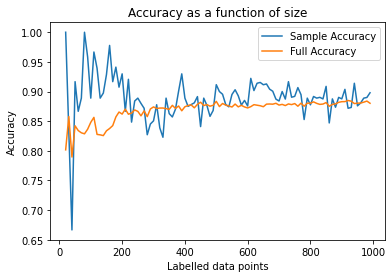

In [69]:
import matplotlib.pyplot as plt

# Assuming the sizes are from 10 to 100 (exclusive) with step 10
sizes = list(range(20, 1000, 10))

# Create a new figure
plt.figure()

# Plot sample_accuracy and full_accuracy as a function of size
plt.plot(sizes, sample_accuracy, label='Sample Accuracy')
plt.plot(sizes, full_accuracy, label='Full Accuracy')

# Add a legend
plt.legend()

# Add title and labels
plt.title('Accuracy as a function of size')
plt.xlabel('Labelled data points')
plt.ylabel('Accuracy')

# Show the plot
plt.show()

### Uncertainty Based Active Learning